## Создадим датасет

### Начальная установка

Установим необходимые завсимости

In [221]:
# %pip install PySpice

In [222]:
# %conda install -c conda-forge ngspice-exe

In [223]:
# %conda install -c conda-forge ngspice

In [224]:
# %conda install -c conda-forge ngspice-lib

### Необходимый импорт

In [27]:
import numpy as np
import pandas as pd

In [28]:
from tqdm import tqdm # для progress bar

In [29]:
####################################################################################################

import matplotlib.pyplot as plt
%matplotlib inline

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

Промоделируем работу MOSFET транзистора

In [30]:
spice_library = SpiceLibrary("C:/Users/lario/MyAnacondaProject/example/libraries")

In [31]:
for key in spice_library.models:
    print(key)

ami05nfet
ami05pfet
tsmc018nfet
tsmc018pfet
nfet
pfet
BAV21
BAV21@xyce
2n2222a
ptm32nm_nmos
ptm32nm_pmos
ptm65nm_nmos
ptm65nm_pmos


In [32]:
for key in spice_library.subcircuits:
    print(key)

QS6K1
1N5822
1N4148
d1n5919brl
irf150
LMV981


In [33]:
1 / np.sqrt(5e-7 * 5e-7)

2000000.0

In [34]:
def mos_circuit(params=None, noise=False):
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    
#     circuit.model('NMOS-SH', 'nmos', Kp=190e-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
#     circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'], temp=d['temp'])

#     circuit.include(spice_library['ptm65nm_nmos'])
#     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos', l=d['length'], w=d['width'])
    
    circuit.include(spice_library['tsmc018nfet'])
#     print(help(circuit.MOSFET))
    if noise:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', 
                       l=d['length'] * np.random.normal(1, 0.1 / 3), 
                       w=d['width'] * np.random.normal(1, 0.1 / 3),)
    else:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'])

#     circuit.include(spice_library['QS6K1'])
#     circuit.X(1, 'VD', 'VG', 0, 0, model='QS6K1', l=d['length'], w=d['width'], )
#     circuit.X(1, 'QS6K1', 'VD', 'VG', 0, l=d['length'], w=d['width'], )
    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [35]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s})
        
        if second_source_name == 'temp':
            simulator = circuit.simulator(temperature=s, normal_temperature=25)
        else:
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        y.append(- np.array(analysis.branches['vd']))
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [36]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range, noise=False):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s}, noise=noise)
        
        if second_source_name == 'temp':
            simulator = circuit.simulator(temperature=s, normal_temperature=25)
        else:
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        vd = - np.array(analysis.branches['vd'])
        if noise:
            y.append(vd * np.random.normal(1, 0.08 / 3, len(vd)))
        else:
            y.append(vd)
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [37]:
def plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_x=lambda x: x, func_y=lambda y: y):
    y = np.array(y)
    y = np.where(y <= 0, 1e-15, y)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(func_x(x), func_y(y[i]), label=f'{second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

### Id and Vds

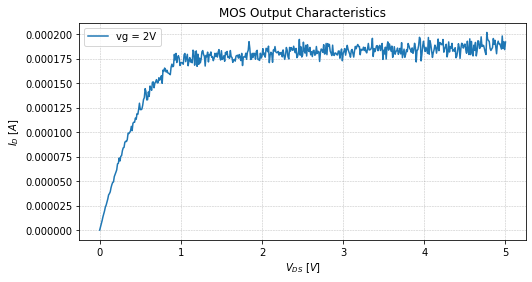

In [38]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
a = [2] * 1
second_source_range = np.array(a)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range, noise=True)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

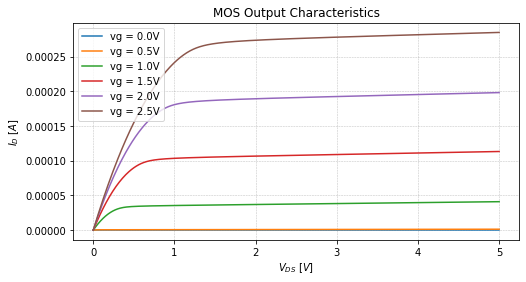

In [39]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

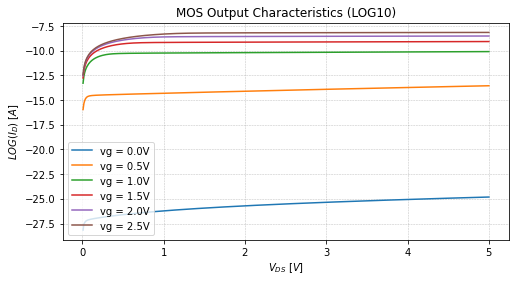

In [40]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$LOG(I_{D})\ [A]$'
title = 'MOS Output Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

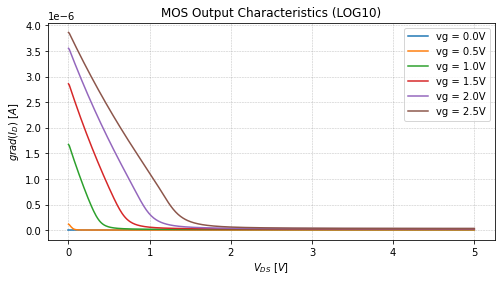

In [41]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$grad(I_{D})\ [A]$'
title = 'MOS Output Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.gradient)

### Id and Vgs

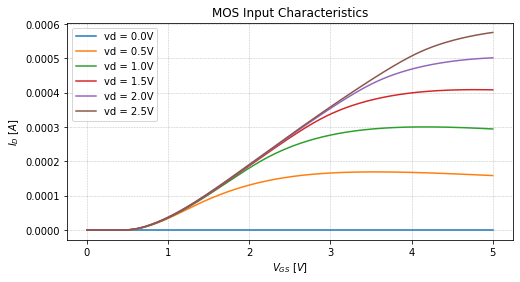

In [42]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

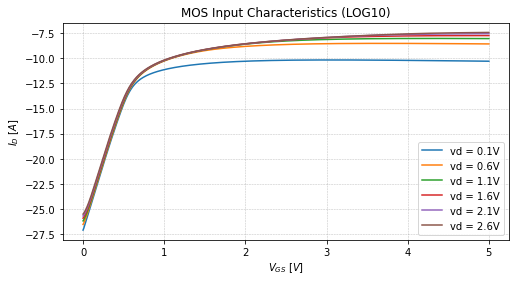

In [43]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0.1, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

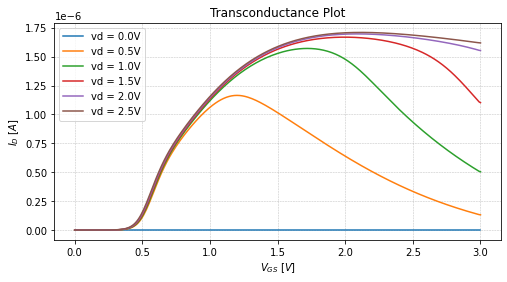

In [44]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.gradient)

### Id and W/L

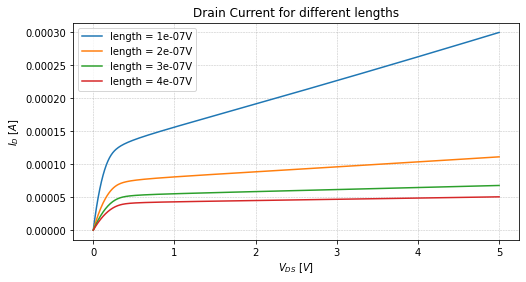

In [45]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

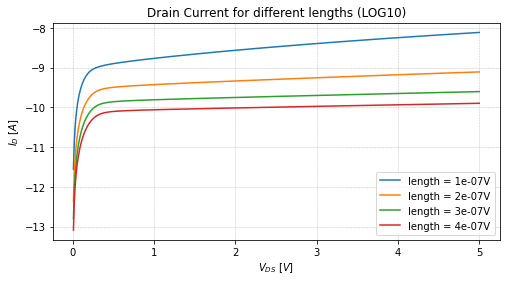

In [46]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

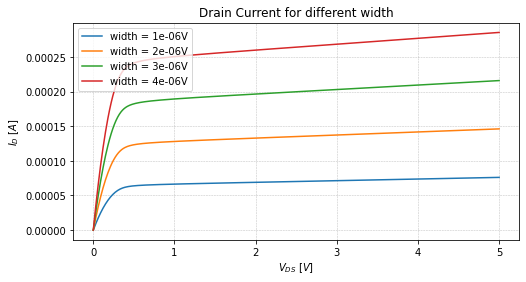

In [47]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

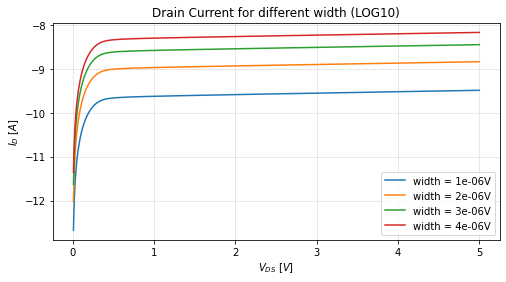

In [48]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

### Id and T

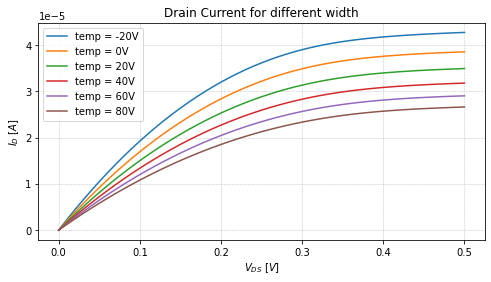

In [49]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'temp'
second_source_range = np.arange(-20, 100, 20)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

### Other

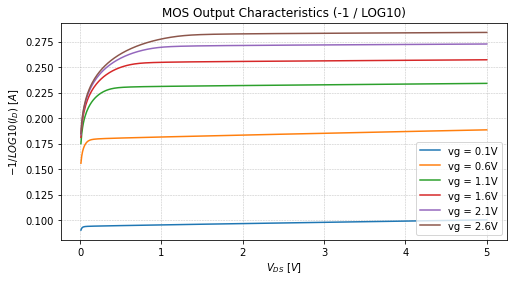

In [50]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0.1, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=lambda y: -1 / np.log10(y))

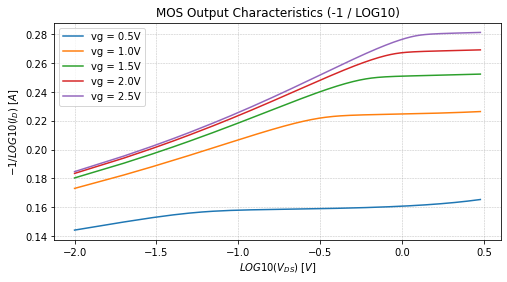

In [51]:
first_source_name = 'vd'
first_source_range = slice(0.01, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0.5, 3, 0.5)
x_label = '$LOG10(V_{DS})\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, 
     func_x=np.log10, func_y=lambda y: -1 / np.log10(y))

In [52]:
def func_3d(vd_slice, vg_range):
    dataset = {'Vds': [], 'Vgs': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    Id = np.array([])
    
    for vg in vg_range:
        circuit = mos_circuit({'vg':vg, })
        simulator = circuit.simulator(temperature=25, normal_temperature=25)
        analysis = simulator.dc(VD=vd_slice)
        
        id_range = (- np.array(analysis.branches['vd']))
        len_id = len(id_range)
        
        vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
        Vds = np.hstack((Vds, vd_range))
        Vgs = np.hstack((Vgs, [vg] * len_id))
        Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [53]:
%matplotlib notebook

<IPython.core.display.Javascript object>


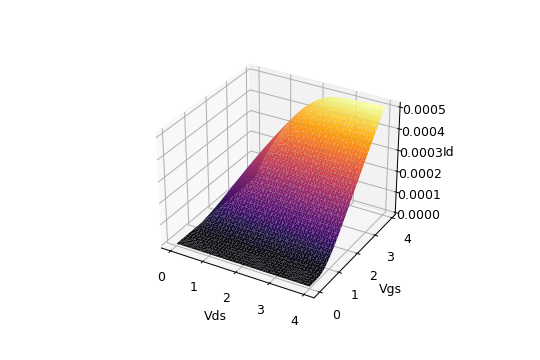

In [54]:
plot3d = func_3d(slice(0, 4, .1), np.arange(0, 4, 0.1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(plot3d['Vds'].to_numpy(), plot3d['Vgs'].to_numpy(), plot3d['Id'].to_numpy(), cmap='inferno')

<IPython.core.display.Javascript object>


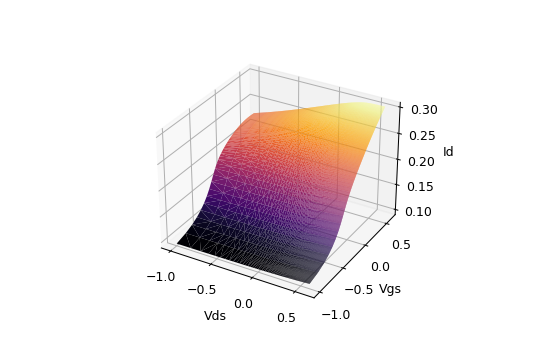

In [55]:
plot3d = func_3d(slice(0.1, 4, .05), np.arange(0.1, 4, .05))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# Replace zeros
# plot3d["Id"].replace({0:1e-10}, inplace=True)
# plot3d["Vgs"].replace({0:1e-3}, inplace=True)
# plot3d["Vds"].replace({0:1e-3}, inplace=True)

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(np.log10(plot3d['Vds'].to_numpy()), 
                np.log10(plot3d['Vgs'].to_numpy()), 
                -1 / np.log10(plot3d['Id'].to_numpy()), cmap='inferno')

### Пороговое напряжение

$ V_{gs}(I_{ds} -> 0) = V_t + \frac{V_{ds}}{2}$  => $ V_{gs}(I_{ds} -> 0) = V_t$

In [56]:
def voltage_th(vg_range, vds, l, w, temp, noise=False):
#     промоделируем транзистор
    circuit = mos_circuit({'vd':vds, 'length': l, 'width': w, 'temp': temp}, noise=noise)
    simulator = circuit.simulator(temperature=temp, normal_temperature=25)
    analysis = simulator.dc(VG=vg_range)
    id_range = - np.array(analysis.branches['vd'])
    if noise:
        id_range = id_range * np.random.normal(1, 0.08 / 3, len(id_range))
    vg_range = np.array(analysis.nodes['vg'])
    
    id_max=max(id_range)
    
    x, y = [], []
    for i in range(len(id_range)):
        if id_range[i] >= id_max * 0.8:
            break
        elif id_range[i] >= id_max * 0.2:
            x.append(vg_range[i])
            y.append(id_range[i])
        
    #полином 1 степени по функции
    p = np.polyfit(x,y, 1)
#     print(p)
    
    return p, x

<IPython.core.display.Javascript object>


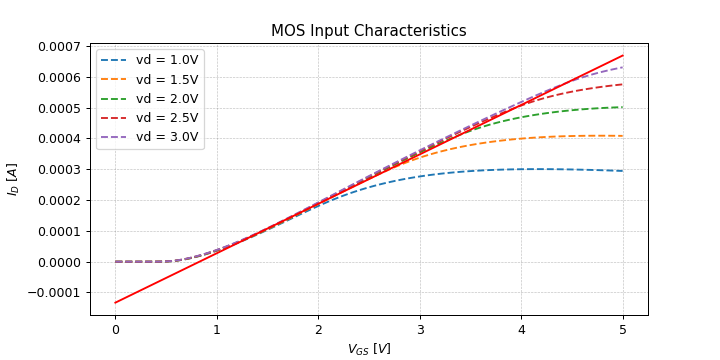

V_t для 1.0 V:  0.7840337833585307
V_t для 1.5 V:  0.8387082710348754
V_t для 2.0 V:  0.8475608600367501
V_t для 2.5 V:  0.8402078125666749
V_t для 3.0 V:  0.8286444437252495
Среднее значение порогового напряжения 0.8278310341444162


In [57]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .05)
second_source_name = 'vd'
second_source_range = np.arange(1, 3.3, 0.5)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
ans = []
l_a, l_b = [], []
for i, s in enumerate(second_source_range):
    ax.plot(x, y[i], '--', label=f'{second_source_name} = {str(s)}V',)
    
    p, x_ = voltage_th(first_source_range, s, 5e-7, 5e-7, 25)
#     ya = np.polyval(p, range(5))
#     ax.plot(range(5), ya)
    l_a.append(p[0])
    l_b.append(p[1])
    print(f'V_t для {s} V: ', -p[1]/p[0])
    ans.append(-p[1]/p[0])
    

Vt = np.mean(ans)
print("Среднее значение порогового напряжения", Vt)

ya = np.polyval([np.mean(l_a), np.mean(l_b)], range(6))
ax.plot(range(6), ya, 'r')
    
ax.legend()
plt.show()


<IPython.core.display.Javascript object>


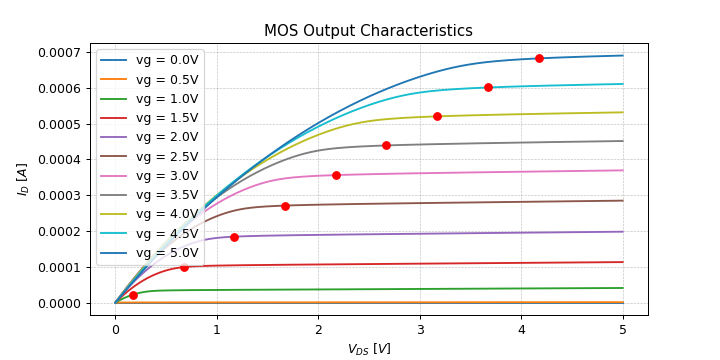

[0.17216897] [array([2.22552035e-05])]
[0.67216897] [array([9.92749255e-05])]
[1.17216897] [array([0.00018436])]
[1.67216897] [array([0.00027118])]
[2.17216897] [array([0.00035633])]
[2.67216897] [array([0.00043919])]
[3.17216897] [array([0.00052041])]
[3.67216897] [array([0.00060108])]
[4.17216897] [array([0.00068236])]


In [58]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 5.1, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

# plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
# Vt += 0.4
for i, s in enumerate(second_source_range):
    ax.plot(x, y[i], label=f'{second_source_name} = {str(s)}V')
    if s > Vt:
        x_, y_ = sweep_source(first_source_name, slice((s - Vt), (s - Vt) + 1, 10), second_source_name, [s, ])
        print(x_, y_)
        ax.plot(x_, y_, 'ro')


    
#     p, x_ = voltage_th(first_source_range, s, 5e-7, 5e-7, 25, noise=True)
#     ya = np.polyval(p, range(5))
#     ax.plot(range(5), ya)
#     print(f'V_t для {s} V: ', -p[1]/p[0])
#     ans.append(-p[1]/p[0])
    

# Vt = np.mean(ans)
# print("Среднее значение порогового напряжения", Vt)
    
ax.legend()
plt.show()

## Датасет для нескольких параметров (Vds, Vgs, Length, Width, Temp)

In [59]:
def mos_circuit(params=None, noise=False):
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])

    circuit.include(spice_library['tsmc018nfet'])
    if noise:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', 
                       l=d['length'] * np.random.normal(1, 0.05 / 3), 
                       w=d['width'] * np.random.normal(1, 0.05 / 3),)
    else:
        circuit.M(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'])
    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [60]:
def _join_cross(vg_range, l_range, w_range, temp_range):
    ans = []
    for vg in vg_range:
        for l in l_range:
            for w in w_range:
                for t in temp_range:
                    ans.append((vg, l, w, t))
    return np.array(ans)

_join_cross([1, 2], [3, 4], [5, 6], [7, 8])[:5]

array([[1, 3, 5, 7],
       [1, 3, 5, 8],
       [1, 3, 6, 7],
       [1, 3, 6, 8],
       [1, 4, 5, 7]])

In [61]:
def dataset_complicated(vd_start, vd_stop, vd_step, params_range, vg_slice_th, noise=False, num_of_meas=1, num_of_th=1):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        for _ in range(num_of_meas):
            
            l_vth = []
            for _ in range(num_of_th):
                s = (vd_stop + vd_start) / 2
                p, _ = voltage_th(vg_slice_th, s, l, w, temp, noise=noise)
                l_vth.append(-p[1]/p[0])
            vth = np.mean(ans)
            
            circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp}, noise=noise)
            simulator = circuit.simulator(temperature=temp, normal_temperature=25)
            
            if vg > vth:
                analysis = simulator.dc(VD=slice(vd_start, vg - vth, vd_step[0]))
                id_range = (- np.array(analysis.branches['vd']))
                vd_range = np.arange(vd_start, vg - vth, vd_step[0])
                
                analysis = simulator.dc(VD=slice(vg - vth, vd_stop, vd_step[1]))
                id_range = np.hstack((id_range, - np.array(analysis.branches['vd'])))
                vd_range = np.hstack((vd_range, np.arange(vg - vth, vd_stop, vd_step[1])))
                
            else:
                analysis = simulator.dc(VD=slice(vd_start, vd_stop, vd_step[1]))
                id_range = (- np.array(analysis.branches['vd']))
                vd_range = np.arange(vd_start, vd_stop, vd_step[1])
                
            len_id = len(id_range)
        
            if noise:
                id_range = id_range * np.random.normal(1, 0.08 / 3, len_id)
        
#             vd_range = np.arange(vd_slice.start, vd_slice.stop, vd_slice.step)
    #         print(len(vd_range), len_id, vd_range, id_range)
        
            Vds = np.hstack((Vds, vd_range))
            Vgs = np.hstack((Vgs, [vg] * len_id))
            L   = np.hstack((L, [l] * len_id))
            W   = np.hstack((W, [w] * len_id))
            T   = np.hstack((T, [temp] * len_id))
            Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
    
    print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [97]:
def dataset(vd_slice, params_range, noise=False, num_of_meas=1):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        for _ in range(num_of_meas):
            circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp}, noise=noise)
            simulator = circuit.simulator(temperature=temp, normal_temperature=25)
            analysis = simulator.dc(VD=vd_slice)
        
            id_range = (- np.array(analysis.branches['vd']))
            len_id = len(id_range)
        
            if noise:
                id_range = id_range * np.random.normal(1, 0.08 / 3, len_id)
        
            vd_range = np.arange(vd_slice.start, vd_slice.stop, vd_slice.step)
    #         print(len(vd_range), len_id, vd_range, id_range)
        
            Vds = np.hstack((Vds, vd_range))
            Vgs = np.hstack((Vgs, [vg] * len_id))
            L   = np.hstack((L, [l] * len_id))
            W   = np.hstack((W, [w] * len_id))
            T   = np.hstack((T, [temp] * len_id))
            Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
    
    print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [98]:
# data = dataset(slice(0.25, .1, .25), [(0.25, 200e-9, 200e-9, 25), (0.50, 200e-9, 200e-9, 25)], noise=True, num_of_meas=5)
# data

In [63]:
np.arange(2, 9, 3) * 1e-7

array([2.e-07, 5.e-07, 8.e-07])

In [64]:
# len(data['Vds'])

len(W) + len(L) = 9 (шт) -- Всего транзисторов

In [65]:
params_range = _join_cross(vg_range=np.arange(0.25, 3.1, .25),
                           l_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           w_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           temp_range=np.arange(0, 51, 25),
                           )
data = dataset(slice(0.25, 3.1, .25), params_range, noise=True, num_of_meas=5)
data

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:09<00:00, 33.94it/s]


,Vds,Vgs,L,W,T,Id
0,0.25,0.25,2.000000e-07,2.000000e-07,0.0,2.869909e-10
1,0.50,0.25,2.000000e-07,2.000000e-07,0.0,3.619992e-10
2,0.75,0.25,2.000000e-07,2.000000e-07,0.0,4.490921e-10
3,1.00,0.25,2.000000e-07,2.000000e-07,0.0,5.607896e-10
4,1.25,0.25,2.000000e-07,2.000000e-07,0.0,7.004924e-10
...,...,...,...,...,...,...
19435,2.00,3.00,1.000000e-06,1.000000e-06,50.0,4.082598e-04
19436,2.25,3.00,1.000000e-06,1.000000e-06,50.0,4.321808e-04
19437,2.50,3.00,1.000000e-06,1.000000e-06,50.0,4.262513e-04
19438,2.75,3.00,1.000000e-06,1.000000e-06,50.0,4.373190e-04


In [66]:
data.shape

(19440, 6)

Сохраним и загрузим датасет

In [67]:
file_name = 'mosfet.csv'
data.to_csv(file_name, index=None)

In [68]:
df = pd.read_csv('mosfet.csv')
df

,Vds,Vgs,L,W,T,Id
0,0.25,0.25,2.000000e-07,2.000000e-07,0.0,2.869909e-10
1,0.50,0.25,2.000000e-07,2.000000e-07,0.0,3.619992e-10
2,0.75,0.25,2.000000e-07,2.000000e-07,0.0,4.490921e-10
3,1.00,0.25,2.000000e-07,2.000000e-07,0.0,5.607896e-10
4,1.25,0.25,2.000000e-07,2.000000e-07,0.0,7.004924e-10
...,...,...,...,...,...,...
19435,2.00,3.00,1.000000e-06,1.000000e-06,50.0,4.082598e-04
19436,2.25,3.00,1.000000e-06,1.000000e-06,50.0,4.321808e-04
19437,2.50,3.00,1.000000e-06,1.000000e-06,50.0,4.262513e-04
19438,2.75,3.00,1.000000e-06,1.000000e-06,50.0,4.373190e-04


In [69]:
df['Vgs'].unique()

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  ])

In [70]:
df['L'].unique()

array([2.e-07, 4.e-07, 1.e-06])

In [71]:
df['W'].unique()

array([2.e-07, 4.e-07, 1.e-06])

In [72]:
df['T'].unique()

array([ 0., 25., 50.])

<IPython.core.display.Javascript object>


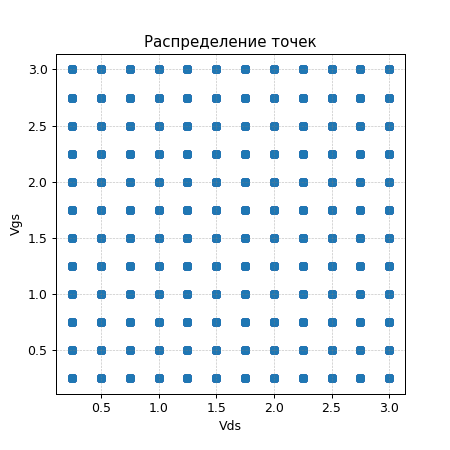

In [73]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


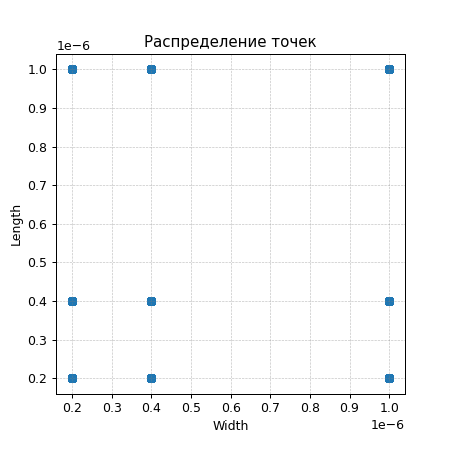

In [74]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

In [75]:
df.iloc[1]['L']

2e-07

<IPython.core.display.Javascript object>


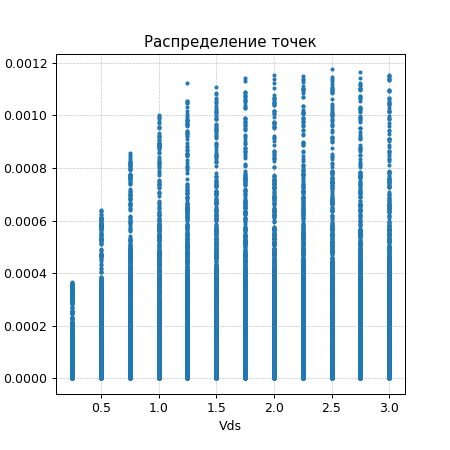

In [76]:
x = df['Vds']
y = df['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Id', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

<IPython.core.display.Javascript object>


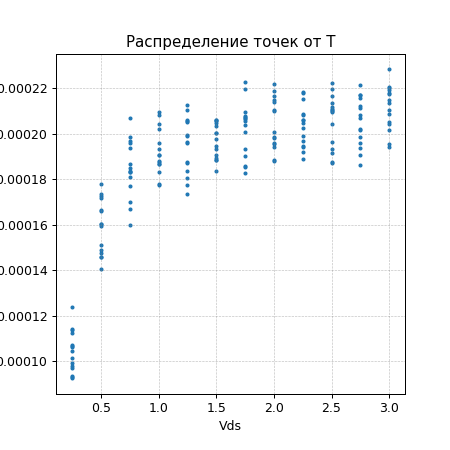

In [77]:
x = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Vds']
y = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек от T')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

### Улучшенный датасет

In [54]:
params_range_complicated = _join_cross(vg_range=np.arange(0.25, 3.1, .25),
                           l_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           w_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           temp_range=np.arange(0, 51, 25),
                           )
new_data = dataset_complicated(0.2, 3.1, [0.2, 0.5],
                               params_range_complicated, 
                               slice(0.1, 3.1, .4),
                               noise=True, 
                               num_of_meas=5,
                               num_of_th=3,
                              )
new_data

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:18<00:00, 17.73it/s]

14040 14040 14040 14040


,Vds,Vgs,L,W,T,Id
0,0.200000,0.25,2.000000e-07,2.000000e-07,0.0,2.632690e-10
1,0.700000,0.25,2.000000e-07,2.000000e-07,0.0,4.240177e-10
2,1.200000,0.25,2.000000e-07,2.000000e-07,0.0,6.468283e-10
3,1.700000,0.25,2.000000e-07,2.000000e-07,0.0,1.002327e-09
4,2.200000,0.25,2.000000e-07,2.000000e-07,0.0,1.426632e-09
...,...,...,...,...,...,...
14035,1.600000,3.00,1.000000e-06,1.000000e-06,50.0,3.788792e-04
14036,1.800000,3.00,1.000000e-06,1.000000e-06,50.0,3.680918e-04
14037,2.000000,3.00,1.000000e-06,1.000000e-06,50.0,3.829836e-04
14038,2.172169,3.00,1.000000e-06,1.000000e-06,50.0,3.827575e-04


In [55]:
new_data.shape

(14040, 6)

In [56]:
file_name = 'mosfet_complicated.csv'
new_data.to_csv(file_name, index=None)

In [57]:
df = pd.read_csv('mosfet_complicated.csv')
df

,Vds,Vgs,L,W,T,Id
0,0.200000,0.25,2.000000e-07,2.000000e-07,0.0,2.632690e-10
1,0.700000,0.25,2.000000e-07,2.000000e-07,0.0,4.240177e-10
2,1.200000,0.25,2.000000e-07,2.000000e-07,0.0,6.468283e-10
3,1.700000,0.25,2.000000e-07,2.000000e-07,0.0,1.002327e-09
4,2.200000,0.25,2.000000e-07,2.000000e-07,0.0,1.426632e-09
...,...,...,...,...,...,...
14035,1.600000,3.00,1.000000e-06,1.000000e-06,50.0,3.788792e-04
14036,1.800000,3.00,1.000000e-06,1.000000e-06,50.0,3.680918e-04
14037,2.000000,3.00,1.000000e-06,1.000000e-06,50.0,3.829836e-04
14038,2.172169,3.00,1.000000e-06,1.000000e-06,50.0,3.827575e-04


In [58]:
df['Vgs'].unique()

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  ])

In [59]:
df['Vds'].unique()

array([0.2       , 0.7       , 1.2       , 1.7       , 2.2       ,
       2.7       , 0.17216897, 0.67216897, 1.17216897, 1.67216897,
       2.17216897, 2.67216897, 0.4       , 0.42216897, 0.92216897,
       1.42216897, 1.92216897, 2.42216897, 2.92216897, 0.6       ,
       0.8       , 1.        , 1.4       , 1.6       , 1.8       ,
       2.        ])

<IPython.core.display.Javascript object>


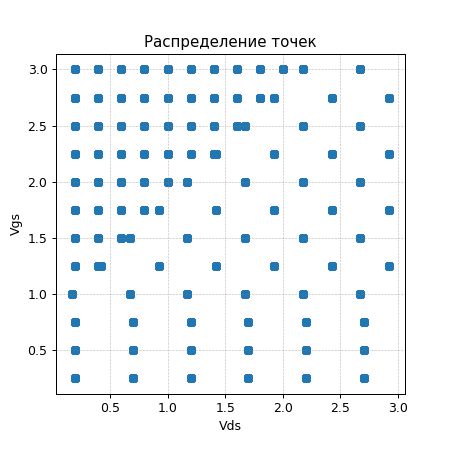

In [60]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


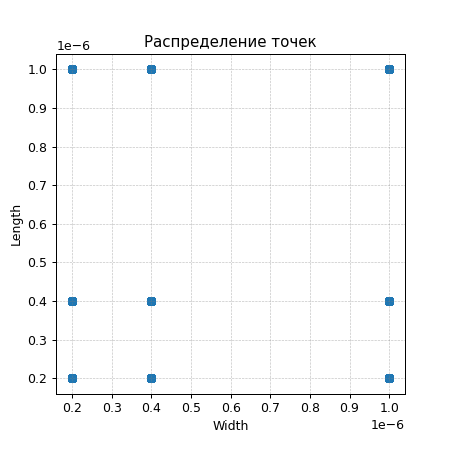

In [61]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


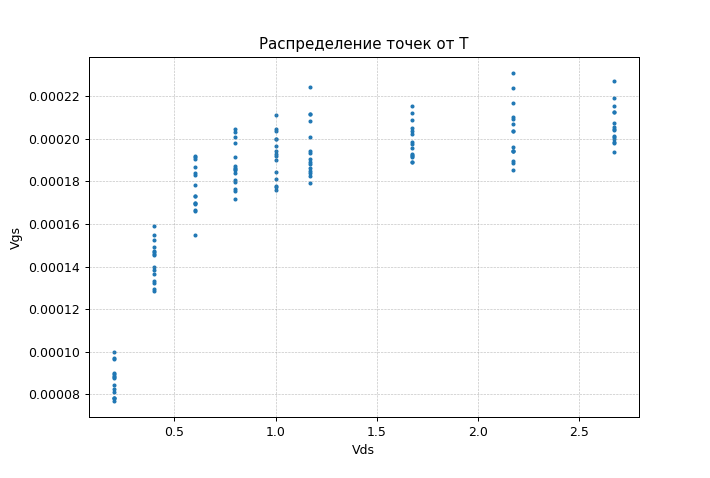

In [62]:
x = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Vds']
y = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек от T')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

### Данные для валидации

Данные внутри области обучения

In [78]:
np.arange(2.5, 12, 3)

array([ 2.5,  5.5,  8.5, 11.5])

In [79]:
np.arange(2, 9, .5)

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ,
       8.5])

In [82]:
params_range_val = _join_cross(vg_range=np.arange(0.1, 3.1, .1),
                           l_range=np.arange(2, 11, 1) * 1e-7, 
                           w_range=np.arange(2, 11, 1) * 1e-7, 
                           temp_range=np.arange(0, 51, 5),
                          )
data_val = dataset(slice(0.1, 3.05, .1), params_range_val)
data_val

100%|████████████████████████████████████████████████████████████████████████████| 26730/26730 [06:35<00:00, 67.58it/s]


,Vds,Vgs,L,W,T,Id
0,0.1,0.1,2.000000e-07,2.000000e-07,0.0,3.273073e-12
1,0.2,0.1,2.000000e-07,2.000000e-07,0.0,3.857130e-12
2,0.3,0.1,2.000000e-07,2.000000e-07,0.0,4.436923e-12
3,0.4,0.1,2.000000e-07,2.000000e-07,0.0,5.018180e-12
4,0.5,0.1,2.000000e-07,2.000000e-07,0.0,5.622239e-12
...,...,...,...,...,...,...
801895,2.6,3.0,1.000000e-06,1.000000e-06,50.0,4.162142e-04
801896,2.7,3.0,1.000000e-06,1.000000e-06,50.0,4.168972e-04
801897,2.8,3.0,1.000000e-06,1.000000e-06,50.0,4.175103e-04
801898,2.9,3.0,1.000000e-06,1.000000e-06,50.0,4.180721e-04


In [ ]:
# params_range = _join_cross(vg_range=np.arange(0.25, 3.1, .25),
#                            l_range=np.array([200e-9, 400e-9, 1000e-9]), 
#                            w_range=np.array([200e-9, 400e-9, 1000e-9]), 
#                            temp_range=np.arange(0, 51, 25),
#                            )
# data = dataset(slice(0.25, 3.1, .25), params_range, noise=True, num_of_meas=5)
# data

In [90]:
file_name = 'mosfet_val_0.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


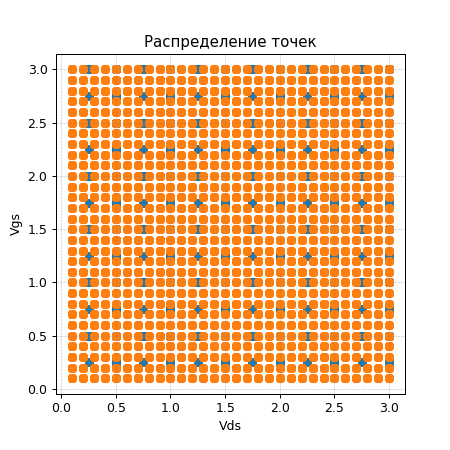

In [91]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

<IPython.core.display.Javascript object>


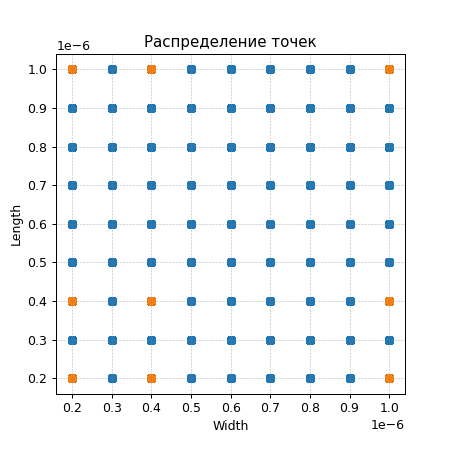

In [92]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

Валидационные данные вне области обучения

In [100]:
params_range_val = _join_cross(vg_range=np.arange(0, 6, .1),
                           l_range=np.arange(2, 18, 3) * 1e-7, 
                           w_range=np.arange(2, 18, 3) * 1e-7, 
                           temp_range=np.arange(0, 25, 101),
                          )
data_val = dataset(slice(0, 6.05, .1), params_range_val)
data_val

100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.24it/s]


131760 131760 131760 131760


,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.1,0.0,2.000000e-07,2.000000e-07,0.0,7.807782e-13
2,0.2,0.0,2.000000e-07,2.000000e-07,0.0,5.893827e-13
3,0.3,0.0,2.000000e-07,2.000000e-07,0.0,8.094150e-13
4,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
...,...,...,...,...,...,...
131755,5.6,5.9,1.700000e-06,1.700000e-06,0.0,1.093667e-03
131756,5.7,5.9,1.700000e-06,1.700000e-06,0.0,1.105809e-03
131757,5.8,5.9,1.700000e-06,1.700000e-06,0.0,1.117707e-03
131758,5.9,5.9,1.700000e-06,1.700000e-06,0.0,1.129364e-03


In [62]:
file_name = 'mosfet_val_1.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


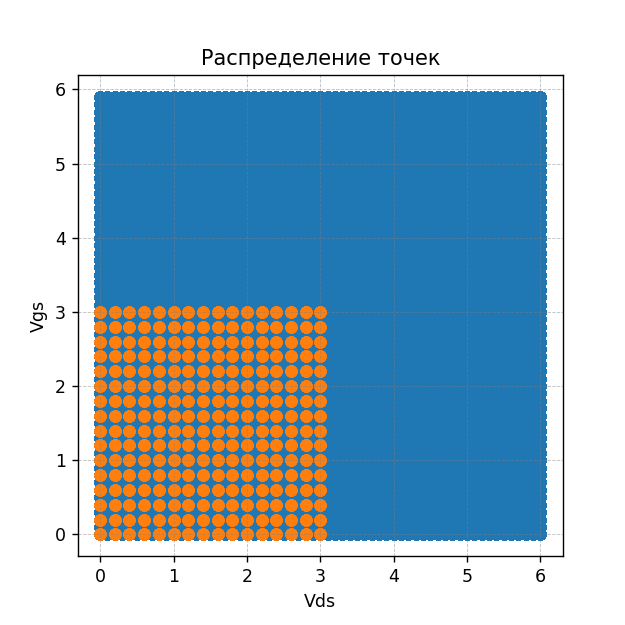

In [65]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


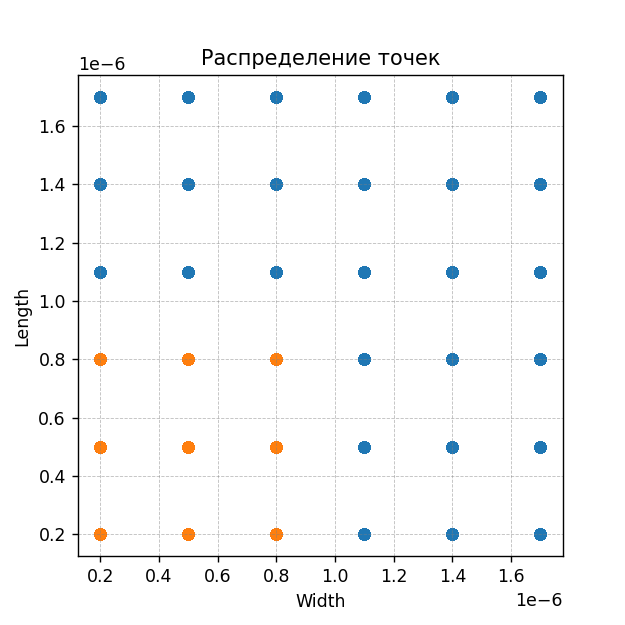

In [66]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Данные для графиков

In [103]:
data_val = dataset(slice(0.1, 6.05, .1), [(0.1, 2 * 1e-7, 2 * 1e-7, 25)])

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.41it/s]

60 60 60 60


In [104]:
file_name = 'mosfet_val_3.csv'
data_val.to_csv(file_name, index=None)

In [105]:
data_val = dataset(slice(0, 6.05, .1), [(0.5, 2 * 1e-7, 2 * 1e-7, 25)])
file_name = 'mosfet_val_4.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.41it/s]

61 61 61 61


In [106]:
data_val = dataset(slice(0, 6.05, .1), [(2, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_5.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.42it/s]

61 61 61 61


In [108]:
data_val = dataset(slice(0, 6.05, .1), [(5, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_6.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.30it/s]

61 61 61 61


In [109]:
data_val = dataset(slice(0, 8.05, .1), [(2, 15 * 1e-7, 15 * 1e-7, 65)])
file_name = 'mosfet_val_7.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.35it/s]

81 81 81 81


In [133]:
data_val = dataset(slice(0, 6.005, .01), [(2, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_8.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.56it/s]

601 601 601 601


<IPython.core.display.Javascript object>


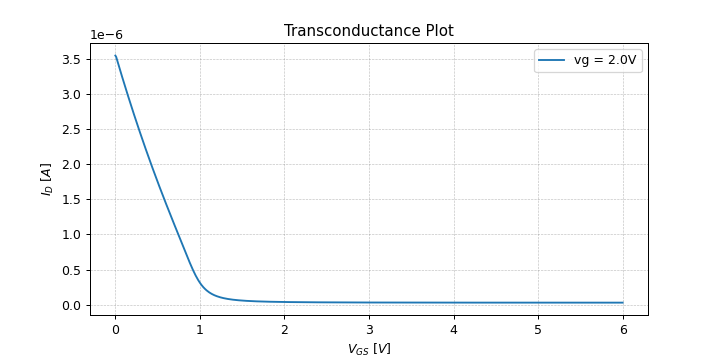

In [134]:
x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, data_val['Vds'], [data_val['Id'],], 'vg', data_val['Vgs'].unique(), func_y=np.gradient)

In [135]:
params_range_val = _join_cross(vg_range=np.arange(0.1, 5.1, .01),
                           l_range=[500e-9,], 
                           w_range=[500e-9,], 
                           temp_range=[25,],
                          )
data_val = dataset(slice(2.0, 2.1, 1), params_range_val)
file_name = 'mosfet_val_9.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 158.10it/s]

500 500 500 500


<IPython.core.display.Javascript object>


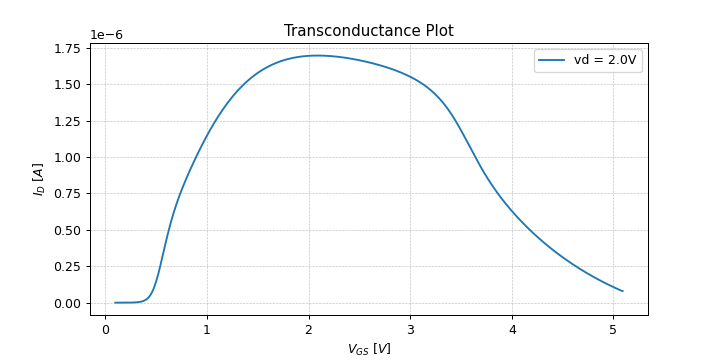

In [136]:
x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, data_val['Vgs'], [data_val['Id'],], 'vd', data_val['Vds'].unique(), func_y=np.gradient)